In [27]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import csv
from csv import writer



#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam


#custom functions import
from ts_functions import time_window_generator
from aux_functions import aux_functions


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [28]:
#option flags
debug_mode = True
debug_output_n = 2

performance_log = True
data_log_csv_path = "training_log/sm_ma_gc_hs300_10win.csv"


In [29]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\index300_05_22_day.csv")

In [30]:
drop_list = ['change']

df = pd.read_csv(filename).drop(drop_list, axis=1)

In [31]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,600783.SH,20221215,13.63,13.63,13.38,13.58,13.55,0.2214,38397.67,51819.5570
1,600783.SH,20221214,13.54,13.82,13.42,13.55,13.46,0.6686,57557.68,78307.7080
2,600783.SH,20221213,13.12,13.65,13.10,13.46,13.24,1.6616,74087.26,99829.4500
3,600783.SH,20221212,13.25,13.46,13.04,13.24,13.29,-0.3762,60428.45,79917.9930
4,600783.SH,20221209,13.56,13.60,13.19,13.29,13.53,-1.7738,66449.00,88408.6250
...,...,...,...,...,...,...,...,...,...,...
1743021,002064.SZ,20060829,9.60,9.79,9.50,9.65,9.63,0.2100,58861.23,56827.0509
1743022,002064.SZ,20060828,9.61,9.91,9.42,9.63,9.54,0.9400,75694.74,73239.1825
1743023,002064.SZ,20060825,9.22,10.00,9.13,9.54,9.28,2.8000,121564.97,115534.6703
1743024,002064.SZ,20060824,8.91,9.37,8.85,9.28,9.18,1.0900,110143.17,100371.4400


In [32]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
count,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06
mean,2.015044e+07,2.407597e+01,2.461099e+01,2.359643e+01,2.411183e+01,2.409182e+01,9.849662e-02,3.072499e+05,4.143607e+05
std,4.886860e+04,5.550575e+01,5.663507e+01,5.447674e+01,5.558351e+01,5.553809e+01,3.230163e+00,7.277838e+05,8.559828e+05
min,2.005051e+07,1.700000e-01,1.800000e-01,1.600000e-01,1.700000e-01,1.700000e-01,-4.906000e+01,5.000000e+00,1.872000e+00
25%,2.011082e+07,6.710000e+00,6.840000e+00,6.600000e+00,6.720000e+00,6.720000e+00,-1.326700e+00,4.509841e+04,6.219120e+04
50%,2.016011e+07,1.265000e+01,1.293000e+01,1.241000e+01,1.268000e+01,1.267000e+01,0.000000e+00,1.195087e+05,1.619238e+05
75%,2.019101e+07,2.469000e+01,2.520000e+01,2.420000e+01,2.472000e+01,2.470000e+01,1.390000e+00,3.034760e+05,4.145728e+05
max,2.022122e+07,2.587980e+03,2.627880e+03,2.485000e+03,2.601000e+03,2.601000e+03,6.210000e+02,5.135467e+07,6.999139e+07


# Model DataFrame preprocessing

In [33]:
#split data into different stock
# stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]

stock_list = []

for ts_code, x in df.groupby('ts_code'):
    stock_list.append(x.copy().sort_values("trade_date", ascending = False).reset_index().drop('index', axis=1))




#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  577


# ADD HS300 into the df

In [34]:
hs300_filename = os.path.join(fileDir, r"stock_data\hs300index_05_22_day.csv")

df_hs300 = pd.read_csv(hs300_filename).drop(['index_ts_code', 'index_vol', 'index_change', 'index_amount'], axis=1).sort_values("index_trade_date", ascending = True)

display(df_hs300)

,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
4285,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
4284,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
4283,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4282,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4281,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
4,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
2,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
1,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [35]:
# #append hs300 by matching dates
# invalid_stock_list = []# the stock that is fucked


# for i in range(len(stock_list)):
#     stock = stock_list[i]
#     if stock['trade_date'].iloc[-1] != df_hs300['index_trade_date'].iloc[-1]:
#         invalid_stock_list.append(i)


In [36]:
# # for i in invalid_stock_list:
# #     print(stock_list[i].head(1))

# invalid_stock_list = sorted(invalid_stock_list, reverse=True)

# print(invalid_stock_list)


# for i in invalid_stock_list:
#     stock_list.pop(i)

In [37]:
# t1 = pd.concat([stock_list[2], df_hs300], axis=1, join='inner') 
# display(t1.head(-5))





In [38]:
stock_list[2]['trade_date']
print(len(stock_list[2]['trade_date']))

tx = df_hs300[df_hs300['index_trade_date'].isin(stock_list[2]['trade_date'])].sort_values("index_trade_date", ascending = False).reset_index().drop('index', axis=1)
display(tx)

display(df_hs300)

3919


,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,20221215,3951.9885,3954.6720,3963.5002,3926.4997,3954.8857,-0.0733
1,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333
2,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
3,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
4,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
...,...,...,...,...,...,...,...
3914,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
3915,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
3916,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
3917,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292


,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
4285,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
4284,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
4283,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4282,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4281,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
4,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
2,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
1,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [39]:
#concat

for i in range(len(stock_list)):

    temp = df_hs300[df_hs300['index_trade_date'].isin(stock_list[i]['trade_date'])].sort_values("index_trade_date", ascending = False).reset_index().drop('index', axis=1)
    stock_list[i] = pd.concat([stock_list[i], temp], axis=1, join='inner').drop('index_trade_date', axis=1)




In [40]:
display(stock_list[0])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000001.SZ,20221215,13.14,13.28,12.94,13.10,13.23,-0.9826,835349.26,1.094434e+06,3951.9885,3954.6720,3963.5002,3926.4997,3954.8857,-0.0733
1,000001.SZ,20221214,13.23,13.40,13.08,13.23,13.24,-0.0755,974061.10,1.287868e+06,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333
2,000001.SZ,20221213,13.15,13.36,13.14,13.24,13.11,0.9916,902285.13,1.194285e+06,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
3,000001.SZ,20221212,13.58,13.58,13.06,13.11,13.70,-4.3066,1392584.28,1.848278e+06,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
4,000001.SZ,20221209,13.40,13.75,13.35,13.70,13.36,2.5449,1615831.92,2.197502e+06,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,000001.SZ,20050513,6.19,6.24,5.90,6.02,6.19,-2.7500,111481.38,6.729219e+04,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
4136,000001.SZ,20050512,6.18,6.34,6.14,6.19,6.19,0.0000,79396.48,4.938704e+04,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4137,000001.SZ,20050511,6.28,6.40,6.12,6.19,6.31,-1.9000,106868.37,6.681369e+04,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4138,000001.SZ,20050510,6.09,6.36,5.97,6.31,6.09,3.6100,108414.13,6.733231e+04,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292


In [41]:
# #check time matching
# for stock in stock_list:
#     print(stock['trade_date'].isin(stock['index_trade_date']).value_counts())

In [42]:
display(stock_list[0])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000001.SZ,20221215,13.14,13.28,12.94,13.10,13.23,-0.9826,835349.26,1.094434e+06,3951.9885,3954.6720,3963.5002,3926.4997,3954.8857,-0.0733
1,000001.SZ,20221214,13.23,13.40,13.08,13.23,13.24,-0.0755,974061.10,1.287868e+06,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333
2,000001.SZ,20221213,13.15,13.36,13.14,13.24,13.11,0.9916,902285.13,1.194285e+06,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
3,000001.SZ,20221212,13.58,13.58,13.06,13.11,13.70,-4.3066,1392584.28,1.848278e+06,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
4,000001.SZ,20221209,13.40,13.75,13.35,13.70,13.36,2.5449,1615831.92,2.197502e+06,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,000001.SZ,20050513,6.19,6.24,5.90,6.02,6.19,-2.7500,111481.38,6.729219e+04,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
4136,000001.SZ,20050512,6.18,6.34,6.14,6.19,6.19,0.0000,79396.48,4.938704e+04,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4137,000001.SZ,20050511,6.28,6.40,6.12,6.19,6.31,-1.9000,106868.37,6.681369e+04,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4138,000001.SZ,20050510,6.09,6.36,5.97,6.31,6.09,3.6100,108414.13,6.733231e+04,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292


# add time periodicity

In [8]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [9]:
if debug_mode:
    print(date_time_db[0])

314360   2001-05-29
314359   2001-05-30
314358   2001-05-31
314357   2001-06-01
314356   2001-06-04
            ...    
309365   2022-08-19
309364   2022-08-22
309363   2022-08-23
309362   2022-08-24
309361   2022-08-25
Name: trade_date, Length: 5000, dtype: datetime64[ns]


In [10]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [11]:
if debug_mode:
    date_time_stamp_db[0]

In [12]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

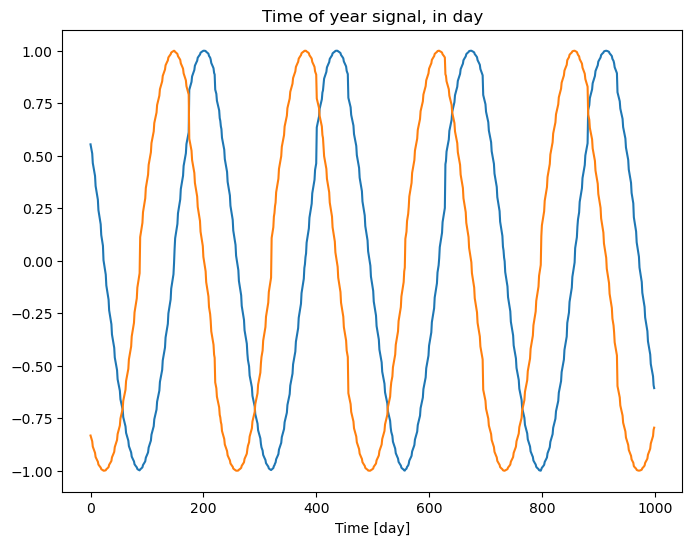

In [13]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [14]:
if debug_mode:
    stock_list[5].head()

In [15]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    stock.pop("pre_close") #pop previous day close price

In [16]:
if debug_mode:
    stock_list[0].head()

# MA implementation

In [17]:
ma_label = 'open'

In [18]:
for stock in stock_list:
    
    #MA

    processing_row = stock[ma_label].to_frame()

    stock['sma5'] = processing_row[ma_label].rolling(5).mean()

    stock['ema5'] = processing_row[ma_label].ewm(span=5).mean()

    stock['ema20'] = processing_row[ma_label].ewm(span=20).mean()

    stock['ema50'] = processing_row[ma_label].ewm(span=50).mean()

    

    #golden cross

    stock['ema20_50_GC'] = np.where(stock['ema20'] > stock['ema50'], 1, 0)


    stock.dropna(inplace=True)
    

In [19]:
display(stock_list[0])

,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
314356,16.32,16.43,16.02,16.08,-0.22,-1.3500,54364.96,8.782524e+04,0.465381,-0.885111,16.122,16.209479,16.146289,16.131847,1
314355,16.06,16.19,15.86,15.91,-0.17,-1.0600,52559.38,8.380886e+04,0.450086,-0.892985,16.162,16.154857,16.128086,16.118644,1
314354,15.91,16.08,15.85,15.92,0.01,0.0600,43113.66,6.873000e+04,0.434659,-0.900595,16.168,16.068164,16.086851,16.085144,1
314353,15.92,16.00,15.79,15.84,-0.08,-0.5000,52996.08,8.403397e+04,0.419102,-0.907939,16.082,16.016771,16.058010,16.061498,0
314352,15.83,15.87,15.51,15.73,-0.11,-0.6900,38217.87,6.004657e+04,0.403422,-0.915014,16.008,15.952851,16.021436,16.031473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309365,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937,12.260,12.274634,12.512635,13.229321,0
309364,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252,12.318,12.376423,12.519051,13.203858,0
309363,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972,12.386,12.400949,12.512474,13.174295,0
309362,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506,12.422,12.377299,12.495096,13.141185,0


# Final data check

In [20]:
display(stock_list[0])
display(stock_list[50])

,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
314356,16.32,16.43,16.02,16.08,-0.22,-1.3500,54364.96,8.782524e+04,0.465381,-0.885111,16.122,16.209479,16.146289,16.131847,1
314355,16.06,16.19,15.86,15.91,-0.17,-1.0600,52559.38,8.380886e+04,0.450086,-0.892985,16.162,16.154857,16.128086,16.118644,1
314354,15.91,16.08,15.85,15.92,0.01,0.0600,43113.66,6.873000e+04,0.434659,-0.900595,16.168,16.068164,16.086851,16.085144,1
314353,15.92,16.00,15.79,15.84,-0.08,-0.5000,52996.08,8.403397e+04,0.419102,-0.907939,16.082,16.016771,16.058010,16.061498,0
314352,15.83,15.87,15.51,15.73,-0.11,-0.6900,38217.87,6.004657e+04,0.403422,-0.915014,16.008,15.952851,16.021436,16.031473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309365,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937,12.260,12.274634,12.512635,13.229321,0
309364,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252,12.318,12.376423,12.519051,13.203858,0
309363,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972,12.386,12.400949,12.512474,13.174295,0
309362,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506,12.422,12.377299,12.495096,13.141185,0


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50,ema20_50_GC
1686131,17.36,17.37,16.81,16.83,-0.55,-3.1600,4478.16,7615.4939,0.128365,0.991727,17.448,17.398768,17.435277,17.442934,0
1686130,16.75,17.00,16.70,16.90,0.07,0.4200,1840.92,3103.0226,0.145405,0.989372,17.298,17.161699,17.290715,17.315595,0
1686129,17.00,17.20,16.80,17.00,0.10,0.5900,2132.79,3618.6299,0.162403,0.986725,17.178,17.104449,17.235748,17.264923,0
1686128,16.81,17.00,16.81,16.88,-0.12,-0.7100,1723.08,2909.1580,0.179352,0.983785,17.034,17.002314,17.162155,17.199785,0
1686127,16.88,16.90,16.57,16.61,-0.27,-1.6000,2447.59,4074.8680,0.196249,0.980554,16.960,16.960454,17.116896,17.158309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681258,15.05,15.14,14.82,14.82,-0.23,-1.5282,61757.68,92346.9190,-0.732342,-0.680937,15.024,15.020745,14.811555,14.713854,1
1681257,14.79,14.90,14.72,14.75,-0.07,-0.4723,47725.35,70567.6840,-0.766493,-0.642252,15.034,14.943830,14.809502,14.716840,1
1681256,14.79,15.03,14.70,14.84,0.09,0.6102,49639.05,73562.6530,-0.777428,-0.628972,15.002,14.892554,14.807645,14.719709,1
1681255,14.85,15.08,14.47,14.53,-0.31,-2.0889,83996.56,123999.9990,-0.788133,-0.615506,14.982,14.878369,14.811679,14.724818,1


# Models Area

In [21]:
stacked_lstm_1 = Sequential(

    [

        LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 1, activation = 'linear') #output 

    ],

    name = "simple_stacked_lstm_stock_1"

)

In [22]:
stacked_lstm_1_plus = Sequential(

    [

        LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 1, activation = 'linear') #output 

    ],

    name = "simple_stacked_lstm_stock_1_plus"

)

# Training for all models

In [23]:
#data storage
evaluation_result = {}


#meta data
labels = ['open']

eval_iteration = 10 #the number of evaluation iterations for individual stock

In [28]:
#main training loop
stock_training_range = 10 #len(stock_list)

for stock_index in range( 87, 200 ):

    #set up

    current_stock = stock_list[stock_index] #df

    column_indices = {name: i for i, name in enumerate(current_stock.columns)}

    n = len(current_stock)
    num_features = current_stock.shape[1]
    num_row = current_stock.shape[0]

    #split training, cross val and testing data
    #note since this is a time series data, the split is fixed. No randomization
    #no testing data, only cross val data

    train_data_p = 0.7  #percentage of train data
    val_data_p = 0.2

    train_df = current_stock[ 0 : int(n * train_data_p) ]
    val_df = current_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
    test_df = current_stock[int( n * (train_data_p + val_data_p)) : ]


    #debug area
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        print("df instances : ", num_row)
        print("df features : ", num_features)
        display(current_stock)


    if debug_mode and stock_index < debug_output_n : 
        print("train_df instances : ", len(train_df))
        display(train_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(val_df))
        display(val_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(test_df))
        display(test_df)
    ########################################################################


    #normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()

    #compute the z score to normalize data between features
    train_df = (train_df - train_mean)/train_std
    val_df = (val_df - train_mean)/train_std
    test_df = (test_df - train_mean)/train_std


    #visuliazation
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        df_std = (current_stock - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(current_stock.keys(), rotation=90)
    ########################################################################



    #window setup area
    ##############################################################################################

    #set up the 7 timesteps window
    win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_7.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_7)
        aux_functions.window_inspection(win_7, debug_mode, labels)
    


    #set up 30 timesteps window
    win_30 = time_window_generator(input_width = 29, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_30.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_30)
        aux_functions.window_inspection(win_30, debug_mode, labels)

    ##############################################################################################




    #chose model to run and evaluate
    train_target = win_30
    train_model = stacked_lstm_1



    #individual stock model performance evaluate 

    result = []

    #train models for n numbers of iteration to check the performance
    for iter in range(eval_iteration):

        data_model = aux_functions.compile_and_fit(train_model, train_target, epochs=20, es_patience=4, es_monitor='val_loss', es_mode='min')

        result.append([train_model.evaluate(train_target.val), train_model.evaluate(train_target.test)])
    

    average_mape_val = 0
    average_mape_test = 0
    
    for result_i in range(len(result)):
        average_mape_val += result[result_i][0][1]
        average_mape_test += result[result_i][1][1]
    
    average_mape_val = average_mape_val/len(result)
    average_mape_test = average_mape_test/len(result)



    evaluation_result[stock_list[stock_index].name] = [average_mape_val, average_mape_test, result]



    #data logging

    if performance_log == True:

        performance_log_csv = open(data_log_csv_path, 'a', encoding='UTF8', newline='')
        csv_writer = csv.writer(performance_log_csv)
        csv_writer.writerow([stock_list[stock_index].name, average_mape_val, average_mape_test, eval_iteration, len(train_df), len(val_df), len(test_df), train_model.name])
        performance_log_csv.close()


    #garbage collection test 1
    del train_model



Epoch 1/20
96/96 [==============================] - 3s 17ms/step - loss: 0.0103 - mean_absolute_percentage_error: 69.2755 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 64.1569
Epoch 2/20
96/96 [==============================] - 1s 10ms/step - loss: 0.0078 - mean_absolute_percentage_error: 61.7534 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 49.1583
Epoch 3/20
96/96 [==============================] - 1s 10ms/step - loss: 0.0072 - mean_absolute_percentage_error: 65.0079 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 46.8006
Epoch 4/20
96/96 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_absolute_percentage_error: 57.5246 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 48.2543
Epoch 5/20
96/96 [==============================] - 1s 10ms/step - loss: 0.0069 - mean_absolute_percentage_error: 59.5089 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 50.0876
Epoch 6/20
96/96 [==============================] - 1s 10ms/step 

KeyboardInterrupt: 

In [ ]:
#check all output of the dictionaries db

for key, value in evaluation_result.items():
    print("Stock Model for : ", key)
    print("Average MAPE of val data_set : ", value[0])
    print("Average MAPE of test data_set : ", value[1])
    print()

In [ ]:

# header = ["stock_code","Average MAPE of val data_set", "Average MAPE of test data_set", "Iteration_number"]   

# with open("training_log/simple_models.csv", 'w', encoding='UTF8', newline='') as file:

#     writer = csv.writer(file)

#     writer.writerow(header)

#     for key, value in evaluation_result.items():
#         writer.writerow([key, value[0], value[1]])